### Phase 2 (Data Understanding)

In [1]:
# imports
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

### Dataset

Our project utilizes specific datasets from the [**Smart meters in London**](https://www.kaggle.com/datasets/jeanmidev/smart-meters-in-london/data)-dataset, carefully selected based on the project's objective of forecasting daily electricity consumption while considering various factors such as weather conditions. The Smart meters in London-dataset encompass:


**Included in the project:**

- **daily_dataset.csv**: Daily information on household energy consumption.
- **information_households.csv**: Details of household IDs, Acorn groups, and associated files.
- **uk_bank_holidays.csv**: Records bank holidays during the study period.
- **weather_daily_darksky.csv**: Daily weather data from the DarkSky API in London during the study.

**Excluded from the project:**

- **daily_dataset folder**: contains 112 block files with daily information on the energy consumption of households.
- **halfhourly_dataset folder**: contains 112 block files with half-hourly smart meter measurements along with timestamps.
- **hhblock_dataset folder**: contains 112 block files with transposed data of a day for each household (as an array).
- **acorn_details.cs**: provides information on the Acorn groups and profiles of the people within each group.
- **weather_hourly_darksky.csv**: hourly weather data in London during the study.  


This selection ensures that the chosen datasets from the Smart meters in London dataset align closely with our project's objective of predicting daily electricity consumption while considering pertinent factors. Further examination and analysis of the chosen data will be conducted in the subsequent phases.




### Loading the Necessary Datasets

In [2]:
# data sources
daily_data = pd.read_csv('../data/daily_dataset.csv')
acorn_types = pd.read_csv('../data/informations_households.csv')
weather_data = pd.read_csv('../data/weather_daily_darksky.csv')
holidays = pd.read_csv('../data/uk_bank_holidays.csv')

### Printing Statistics for the Datasets

**daily_dataset.csv**

- Number of rows
- Number of duplicate rows
- Data types
- Possible NaN-values

**informations_households.csv**

- Unique values
- Number of unique values

**weather_daily_darksky.csv**

- Printing head(5) to provide a glimpse into the data.

**uk_bank_holidays.csv**

- Printing head(20) to provide a glimpse into the data.

**From all datasets:**

- Following statistics are generated for each dataset using the 'describe()' function:
    - Count of values (excluding NaN values)
    - Mean
    - Standard deviation
    - Minimum value
    - 25% represents the value below which 25% of the dataset's values fall
    - 50% represents the value below which 50% of the dataset's values fall
    - 75% same as above
    - Maximum value of the dataset

In [3]:
# daily dataset
print(daily_data.head())
print(f"Number of rows in dataset: {len(daily_data)}")
print(f"Number of duplicate rows: {daily_data.duplicated().sum()}")
print(f"Data types: {daily_data.dtypes}")
print(f"NaN values: {daily_data.isna().sum()}")

# households
print(acorn_types['Acorn'].nunique())
print(acorn_types['Acorn'].value_counts())

# weather
print(weather_data.head())

# holidays
print(holidays.head(20))

# describes
print(daily_data.describe())
print(acorn_types.describe())
print(weather_data.describe())
print(holidays.describe())

       LCLid         day  energy_median  energy_mean  energy_max  \
0  MAC000131  2011-12-15         0.4850     0.432045       0.868   
1  MAC000131  2011-12-16         0.1415     0.296167       1.116   
2  MAC000131  2011-12-17         0.1015     0.189812       0.685   
3  MAC000131  2011-12-18         0.1140     0.218979       0.676   
4  MAC000131  2011-12-19         0.1910     0.325979       0.788   

   energy_count  energy_std  energy_sum  energy_min  
0            22    0.239146       9.505       0.072  
1            48    0.281471      14.216       0.031  
2            48    0.188405       9.111       0.064  
3            48    0.202919      10.511       0.065  
4            48    0.259205      15.647       0.066  
Number of rows in dataset: 3510433
Number of duplicate rows: 0
Data types: LCLid             object
day               object
energy_median    float64
energy_mean      float64
energy_max       float64
energy_count       int64
energy_std       float64
energy_sum       

### Calculating Averages for Weather Data

- Since the weather data contains hourly measurements, we will calculate daily averages for each weather parameter. This is done to merge the data with other datasets based on the date.

In [4]:
# refactoring weather data

weather_data['temperatureMaxTime'] = pd.to_datetime(weather_data['temperatureMaxTime'])
weather_data['date'] = weather_data['temperatureMaxTime'].dt.date
avg_weather_df = weather_data.groupby('date')[[
    'temperatureMax',
    'temperatureMin',
    'windBearing',
    'cloudCover',
    'windSpeed'
    ]].mean()
avg_weather_df = avg_weather_df.reset_index()
print(avg_weather_df)

           date  temperatureMax  temperatureMin  windBearing  cloudCover  \
0    2011-11-01           15.57            9.68        208.0        0.36   
1    2011-11-02           15.19            8.88        134.0        0.39   
2    2011-11-03           17.41           12.79        154.0        0.52   
3    2011-11-04           15.54           11.53        179.0        0.50   
4    2011-11-05           13.94           10.17        346.0        0.65   
..          ...             ...             ...          ...         ...   
866  2014-03-27           10.04            2.71         75.0        0.44   
867  2014-03-28           12.43            3.85         87.0        0.19   
868  2014-03-29           18.47            7.83        105.0        0.08   
869  2014-03-30           19.82            8.53        114.0        0.31   
870  2014-03-31           16.37           10.98        138.0        0.32   

     windSpeed  
0         2.45  
1         4.39  
2         3.99  
3         2.62  
4 

### Adding Modified Weather Data to the Energy Consumption Dataset

- We will use the 'date' column as the merging point, ensuring that the merged dataset retains one 'date' column. For each row in the merged dataset, weather data corresponding to the same 'date' value will be added.

In [5]:
# adding weather data to consumption dataset
avg_weather_df['date'] = pd.to_datetime(avg_weather_df['date'])
daily_data['day'] = pd.to_datetime(daily_data['day'])
daily_data = daily_data.rename(columns={'day': 'date'})

result_df = pd.merge(daily_data, avg_weather_df, on='date', how='inner')
print(result_df)

             LCLid       date  energy_median  energy_mean  energy_max  \
0        MAC000131 2011-12-15         0.4850     0.432045       0.868   
1        MAC000131 2011-12-16         0.1415     0.296167       1.116   
2        MAC000131 2011-12-17         0.1015     0.189812       0.685   
3        MAC000131 2011-12-18         0.1140     0.218979       0.676   
4        MAC000131 2011-12-19         0.1910     0.325979       0.788   
...            ...        ...            ...          ...         ...   
3458014  MAC004977 2014-02-24         0.0950     0.118458       0.580   
3458015  MAC004977 2014-02-25         0.0675     0.084208       0.176   
3458016  MAC004977 2014-02-26         0.1080     0.120500       0.282   
3458017  MAC004977 2014-02-27         0.0720     0.114062       0.431   
3458018  MAC004977 2014-02-28         0.0970     0.097000       0.097   

         energy_count  energy_std  energy_sum  energy_min  temperatureMax  \
0                  22    0.239146       9.505 

### Adding Holiday Status to Each Date Entry

- We will add information to each row of the 'date' column, indicating whether it is a holiday or not. If a 'holiday' is found for the same date, it will be added as the value for that row; otherwise, the value will be 'No holiday'.

In [6]:
# adding holiday data to concatted weather and consumption set
holidays['Bank holidays'] = pd.to_datetime(holidays['Bank holidays'])
holidays.rename(columns={'Bank holidays': 'date'}, inplace=True)

df = pd.merge(result_df, holidays, on='date', how='left')

df['Type'].fillna('No holiday', inplace=True)

print(df)

             LCLid       date  energy_median  energy_mean  energy_max  \
0        MAC000131 2011-12-15         0.4850     0.432045       0.868   
1        MAC000131 2011-12-16         0.1415     0.296167       1.116   
2        MAC000131 2011-12-17         0.1015     0.189812       0.685   
3        MAC000131 2011-12-18         0.1140     0.218979       0.676   
4        MAC000131 2011-12-19         0.1910     0.325979       0.788   
...            ...        ...            ...          ...         ...   
3458014  MAC004977 2014-02-24         0.0950     0.118458       0.580   
3458015  MAC004977 2014-02-25         0.0675     0.084208       0.176   
3458016  MAC004977 2014-02-26         0.1080     0.120500       0.282   
3458017  MAC004977 2014-02-27         0.0720     0.114062       0.431   
3458018  MAC004977 2014-02-28         0.0970     0.097000       0.097   

         energy_count  energy_std  energy_sum  energy_min  temperatureMax  \
0                  22    0.239146       9.505 

C:\Users\janne\AppData\Local\Temp\ipykernel_24720\3907156579.py:7: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Type'].fillna('No holiday', inplace=True)


### Adding Household Dataset to the Merged Dataset

- This time, we will use the 'LCLid' column for merging, as it serves as the common factor between the datasets.
- Each entry in this merged dataset corresponds to one day's measurement for a single household.

In [7]:
# adding households information to the merged df grouped by 'LCLid'

final_df = pd.merge(df, acorn_types, on='LCLid', how='left')

final_df

,LCLid,date,energy_median,energy_mean,energy_max,energy_count,energy_std,energy_sum,energy_min,temperatureMax,temperatureMin,windBearing,cloudCover,windSpeed,Type,stdorToU,Acorn,Acorn_grouped,file
0,MAC000131,2011-12-15,0.4850,0.432045,0.868,22,0.239146,9.505,0.072,7.97,4.08,234.0,0.42,4.71,No holiday,Std,ACORN-E,Affluent,block_22
1,MAC000131,2011-12-16,0.1415,0.296167,1.116,48,0.281471,14.216,0.031,4.68,1.80,315.0,0.70,3.71,No holiday,Std,ACORN-E,Affluent,block_22
2,MAC000131,2011-12-17,0.1015,0.189812,0.685,48,0.188405,9.111,0.064,5.35,0.24,285.0,0.37,3.99,No holiday,Std,ACORN-E,Affluent,block_22
3,MAC000131,2011-12-18,0.1140,0.218979,0.676,48,0.202919,10.511,0.065,5.49,-0.56,289.0,0.22,3.60,No holiday,Std,ACORN-E,Affluent,block_22
4,MAC000131,2011-12-19,0.1910,0.325979,0.788,48,0.259205,15.647,0.066,6.64,-0.84,235.0,0.47,2.70,No holiday,Std,ACORN-E,Affluent,block_22
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3458014,MAC004977,2014-02-24,0.0950,0.118458,0.580,48,0.093814,5.686,0.052,14.23,7.99,183.0,0.50,5.02,No holiday,ToU,ACORN-E,Affluent,block_33
3458015,MAC004977,2014-02-25,0.0675,0.084208,0.176,48,0.037107,4.042,0.046,11.43,6.79,202.0,0.62,5.69,No holiday,ToU,ACORN-E,Affluent,block_33
3458016,MAC004977,2014-02-26,0.1080,0.120500,0.282,48,0.069332,5.784,0.046,11.29,4.17,227.0,0.26,3.82,No holiday,ToU,ACORN-E,Affluent,block_33
3458017,MAC004977,2014-02-27,0.0720,0.114062,0.431,48,0.094482,5.475,0.047,10.31,3.93,224.0,0.32,4.14,No holiday,ToU,ACORN-E,Affluent,block_33


### Saving the Entire Dataset as a Single .csv File

In [8]:
# saving combined data as a csv file to data folder
""" final_df.to_csv('../data/combined_data.csv', index=False) """


" final_df.to_csv('../data/combined_data.csv', index=False) "

### Exploring Correlations with Heatmap Visualization

- The heatmap visualization using the seaborn library allows us to observe correlations between variables.
    - Different energy measurements show a 100% positive correlation, implying that if one value increases, all others increase proportionally.
        - Consequently, it's inferred that during the modeling phase, no action will be taken with columns containing various energy measurements due to perfect correlation. Doing so would distort results.
    - It's noted that energy consumption has a negative correlation with temperature data, indicating that as temperature rises, energy consumption decreases, and vice versa.
    - Additionally, cloud cover ('cloudCover') shows a notable negative correlation with temperature. As cloud cover increases, temperature tends to decrease, which may indirectly affect energy consumption.

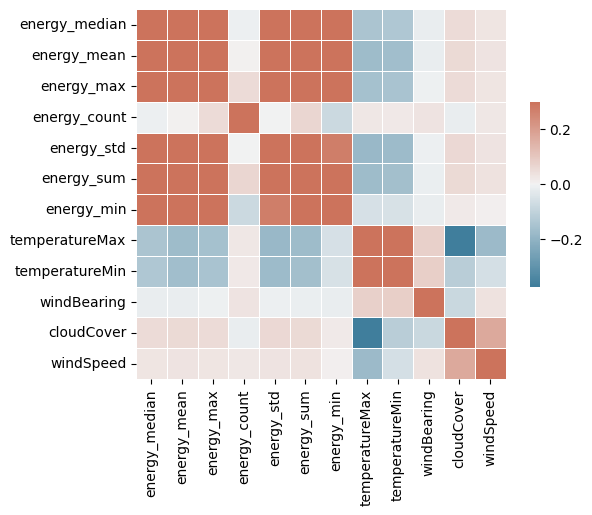

In [9]:
# visualization on raw data
columns_to_plot = [
    'energy_median',
    'energy_mean',
    'energy_max',
    'energy_count',
    'energy_std',
    'energy_sum',
    'energy_min',
    'temperatureMax',
    'temperatureMin',
    'windBearing',
    'cloudCover',
    'windSpeed'
    ]

corr = final_df[columns_to_plot].corr()
cmap = sns.diverging_palette(230, 20, as_cmap=True)
sns.heatmap(corr, cmap=cmap, vmax=.3, center=0, square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

### Linear Plot of Annual Average Energy Consumption

- This time, we will plot the annual average energy consumption linearly.
    - This visualization allows us to observe annual trends in energy consumption. Since the dataset covers a small number of years, definitive conclusions cannot be drawn from this plot.

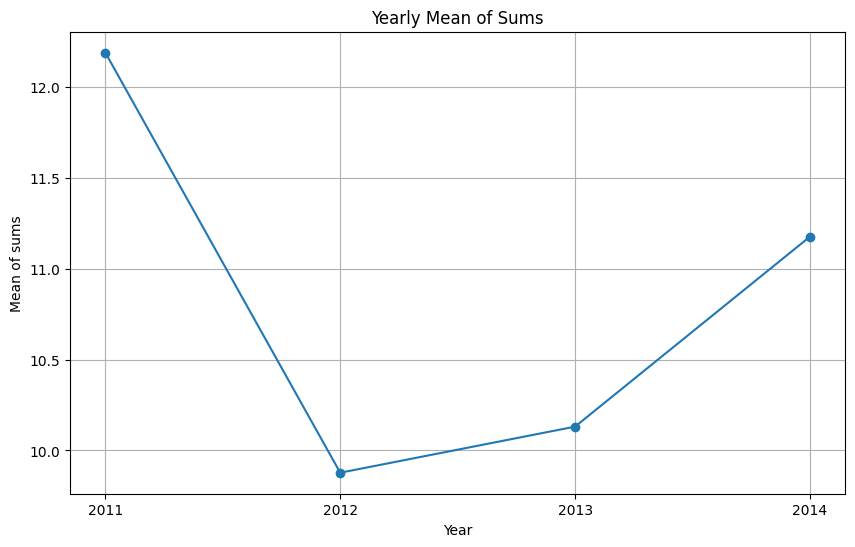

In [10]:
# plotting mean of sum each year

final_df['year'] = final_df['date'].dt.year
grouped_sums = final_df.groupby(['year'])['energy_sum'].mean().reset_index()

mean_of_sums = grouped_sums.groupby('year')['energy_sum'].mean().reset_index()

plt.figure(figsize=(10,6))
plt.plot(mean_of_sums['year'], mean_of_sums['energy_sum'], marker='o', linestyle='-')
plt.xlabel('Year')
plt.ylabel('Mean of sums')
plt.title('Yearly Mean of Sums')
plt.xticks(mean_of_sums['year'])
plt.grid(True)
plt.show()

### Narrowing down the Previous Plot to Monthly Level

- Now, we aim to observe monthly fluctuations in the average sums of energy consumption.
- It's noted that there is limited data for the years 2011 and 2014. Therefore, when considering these years in modeling, variations may be contemplated to decide whether to use data from these years to avoid misinterpretations.
- Otherwise, the trend in energy consumption follows the expected pattern, with lower consumption in summer compared to winter.

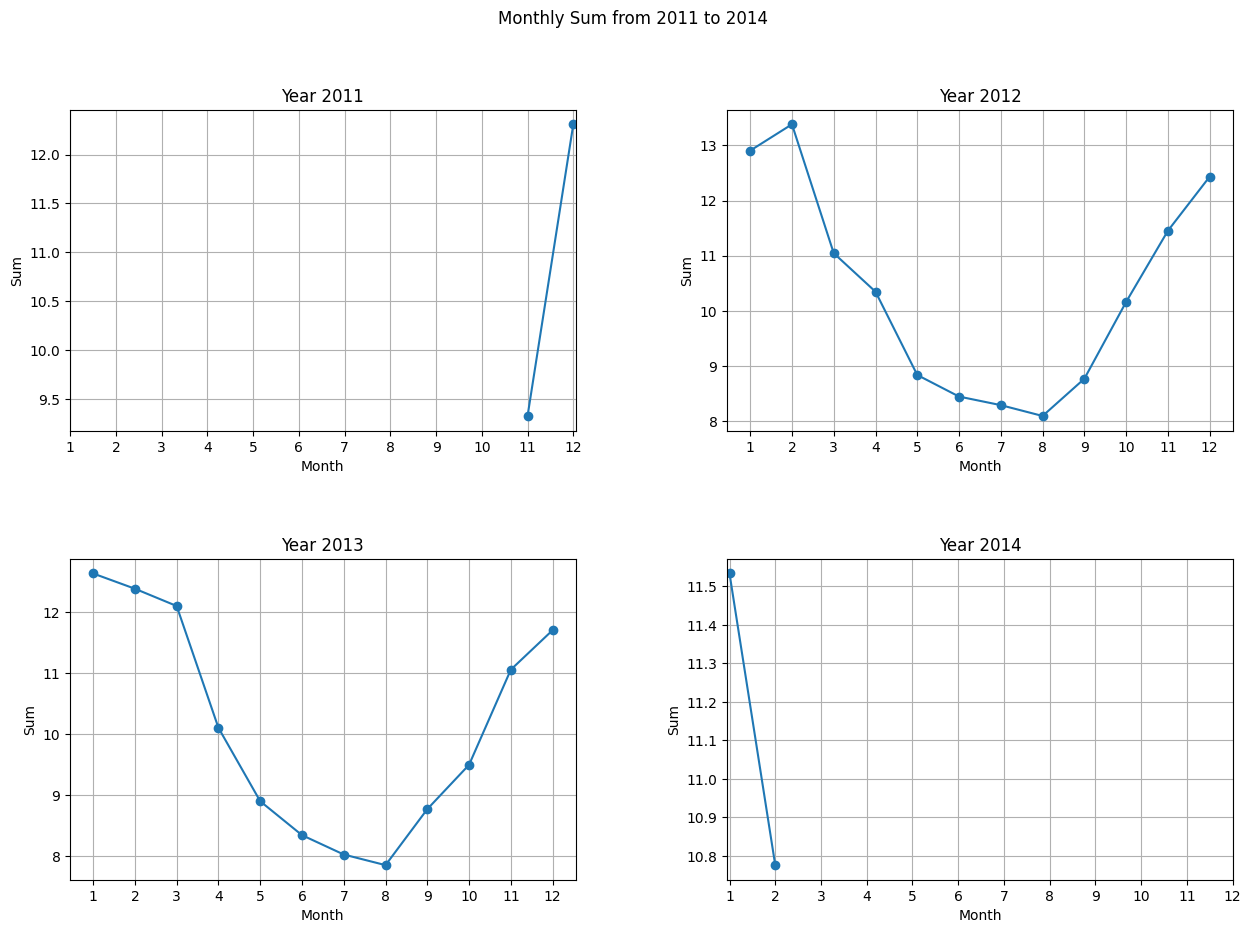

In [11]:
# plotting each month of each year
final_df['year'] = final_df['date'].dt.year
final_df['month'] = final_df['date'].dt.month

fig, axs = plt.subplots(2,2, figsize=(15,10))
fig.suptitle('Monthly Sum from 2011 to 2014')

plt.subplots_adjust(hspace=0.4, wspace=0.3)

years = range(2011, 2015)
for i, year in enumerate(years):
    ax = axs[i//2, i%2]

    yearly_data = final_df[final_df['year'] == year]
    monthly_sums = yearly_data.groupby('month')['energy_sum'].mean().reset_index()

    ax.plot(monthly_sums['month'], monthly_sums['energy_sum'], marker='o', linestyle='-')
    ax.set_title(f"Year {year}")
    ax.set_xlabel('Month')
    ax.set_ylabel('Sum')
    ax.set_xticks(range(1,13))
    ax.grid(True)
plt.show()

### Plotting Holiday Energy Consumption Relative to Total Annual Consumption

- This visualization allows us to observe the impact of holidays on energy consumption relative to the total consumption for the year.
- It will show that some holidays have a noticeable effect on consumption, with the "point" of the holiday plotted at the peak of the total annual consumption curve at that time.
- However, not all holidays have the same effect; some points may be on a descending curve while others are on an ascending one.

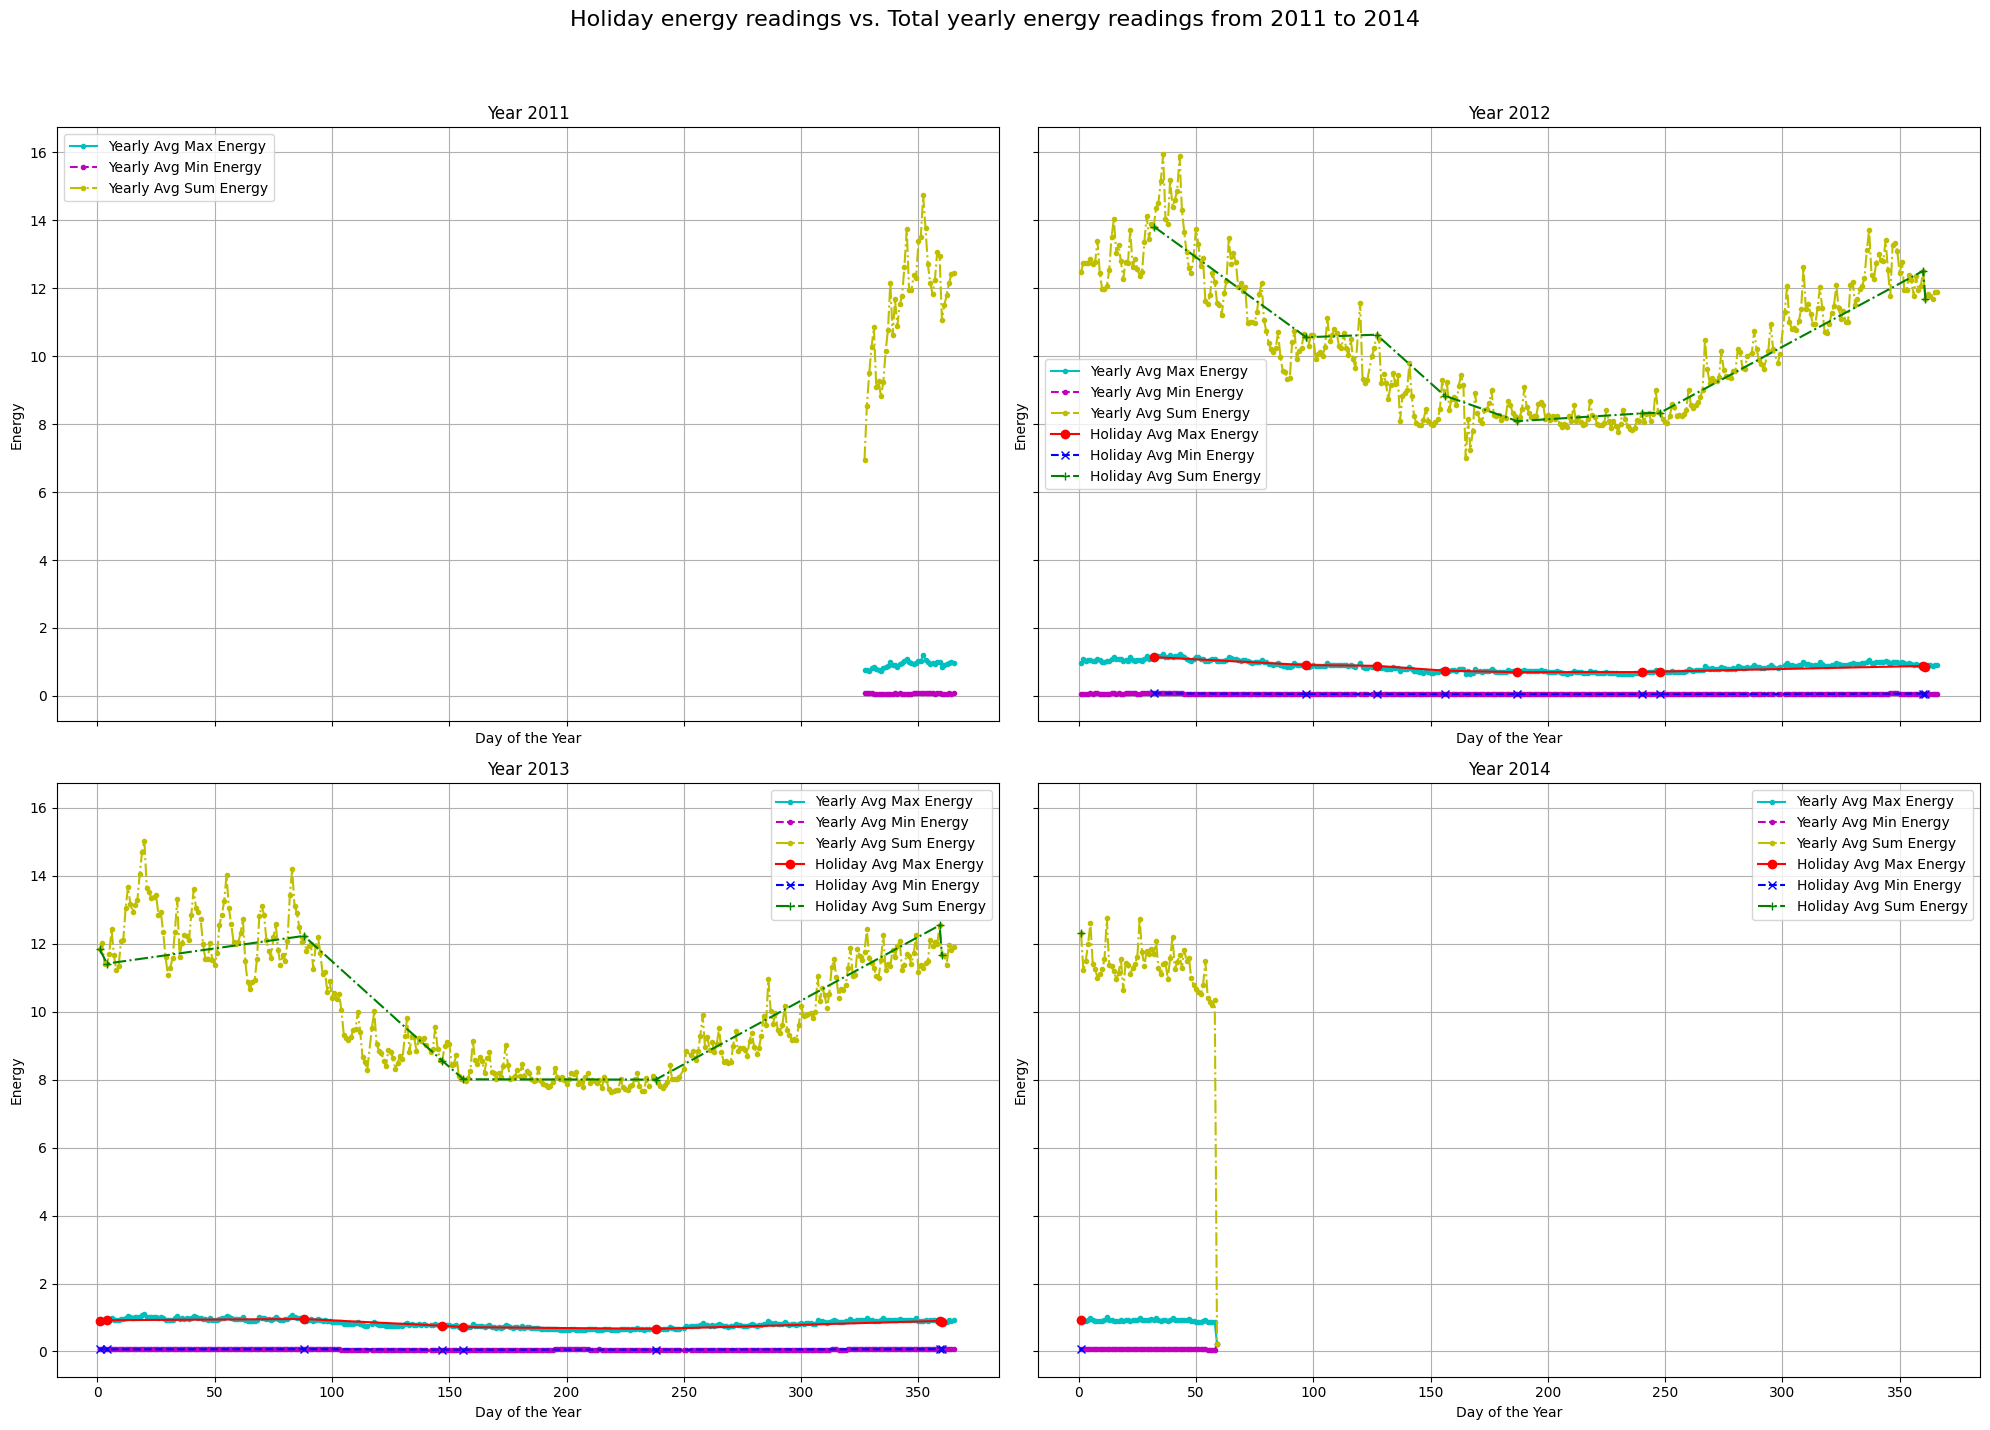

In [12]:

final_df['year'] = final_df['date'].dt.year
final_df['day_of_year'] = final_df['date'].dt.dayofyear

holiday_df = final_df[final_df['Type'] != 'No holiday'].copy()

fig, axs = plt.subplots(2, 2, figsize=(20, 15), sharex='all', sharey='all')
fig.suptitle('Holiday energy readings vs. Total yearly energy readings from 2011 to 2014', fontsize=16)

years = range(2011, 2015)

for i, year in enumerate(years):
    ax = axs[i//2, i%2]
    yearly_data = holiday_df[holiday_df['year'] == year]
    all_yearly_data = final_df[final_df['year'] == year]  # Data for the whole year

    columns_to_aggregate = ['energy_sum', 'energy_max', 'energy_min']
    daily_means_holiday = yearly_data.groupby('day_of_year')[columns_to_aggregate].mean()
    daily_means_all_year = all_yearly_data.groupby('day_of_year')[columns_to_aggregate].mean()  # Daily means for the entire year

    # Plotting entire year data for comparison
    if not daily_means_all_year.empty:
        ax.plot(daily_means_all_year.index, daily_means_all_year['energy_max'], 'c-', label='Yearly Avg Max Energy', marker='.')
        ax.plot(daily_means_all_year.index, daily_means_all_year['energy_min'], 'm--', label='Yearly Avg Min Energy', marker='.')
        ax.plot(daily_means_all_year.index, daily_means_all_year['energy_sum'], 'y-.', label='Yearly Avg Sum Energy', marker='.')
        
    # Plotting holiday data
    if not daily_means_holiday.empty:
        ax.plot(daily_means_holiday.index, daily_means_holiday['energy_max'], 'r-', label='Holiday Avg Max Energy', marker='o')
        ax.plot(daily_means_holiday.index, daily_means_holiday['energy_min'], 'b--', label='Holiday Avg Min Energy', marker='x')
        ax.plot(daily_means_holiday.index, daily_means_holiday['energy_sum'], 'g-.', label='Holiday Avg Sum Energy', marker='+')
        
    ax.set_title(f'Year {year}')
    ax.set_xlabel('Day of the Year')
    ax.set_ylabel('Energy')
    ax.legend(loc='best')
    ax.grid(True)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Searching for Outliers in the Data Using Scatter Plots
- We will plot each value of every numerical column separately to identify outliers.
- By examining these plots, we can easily detect outliers and decide on their removal based on the distribution of data points.

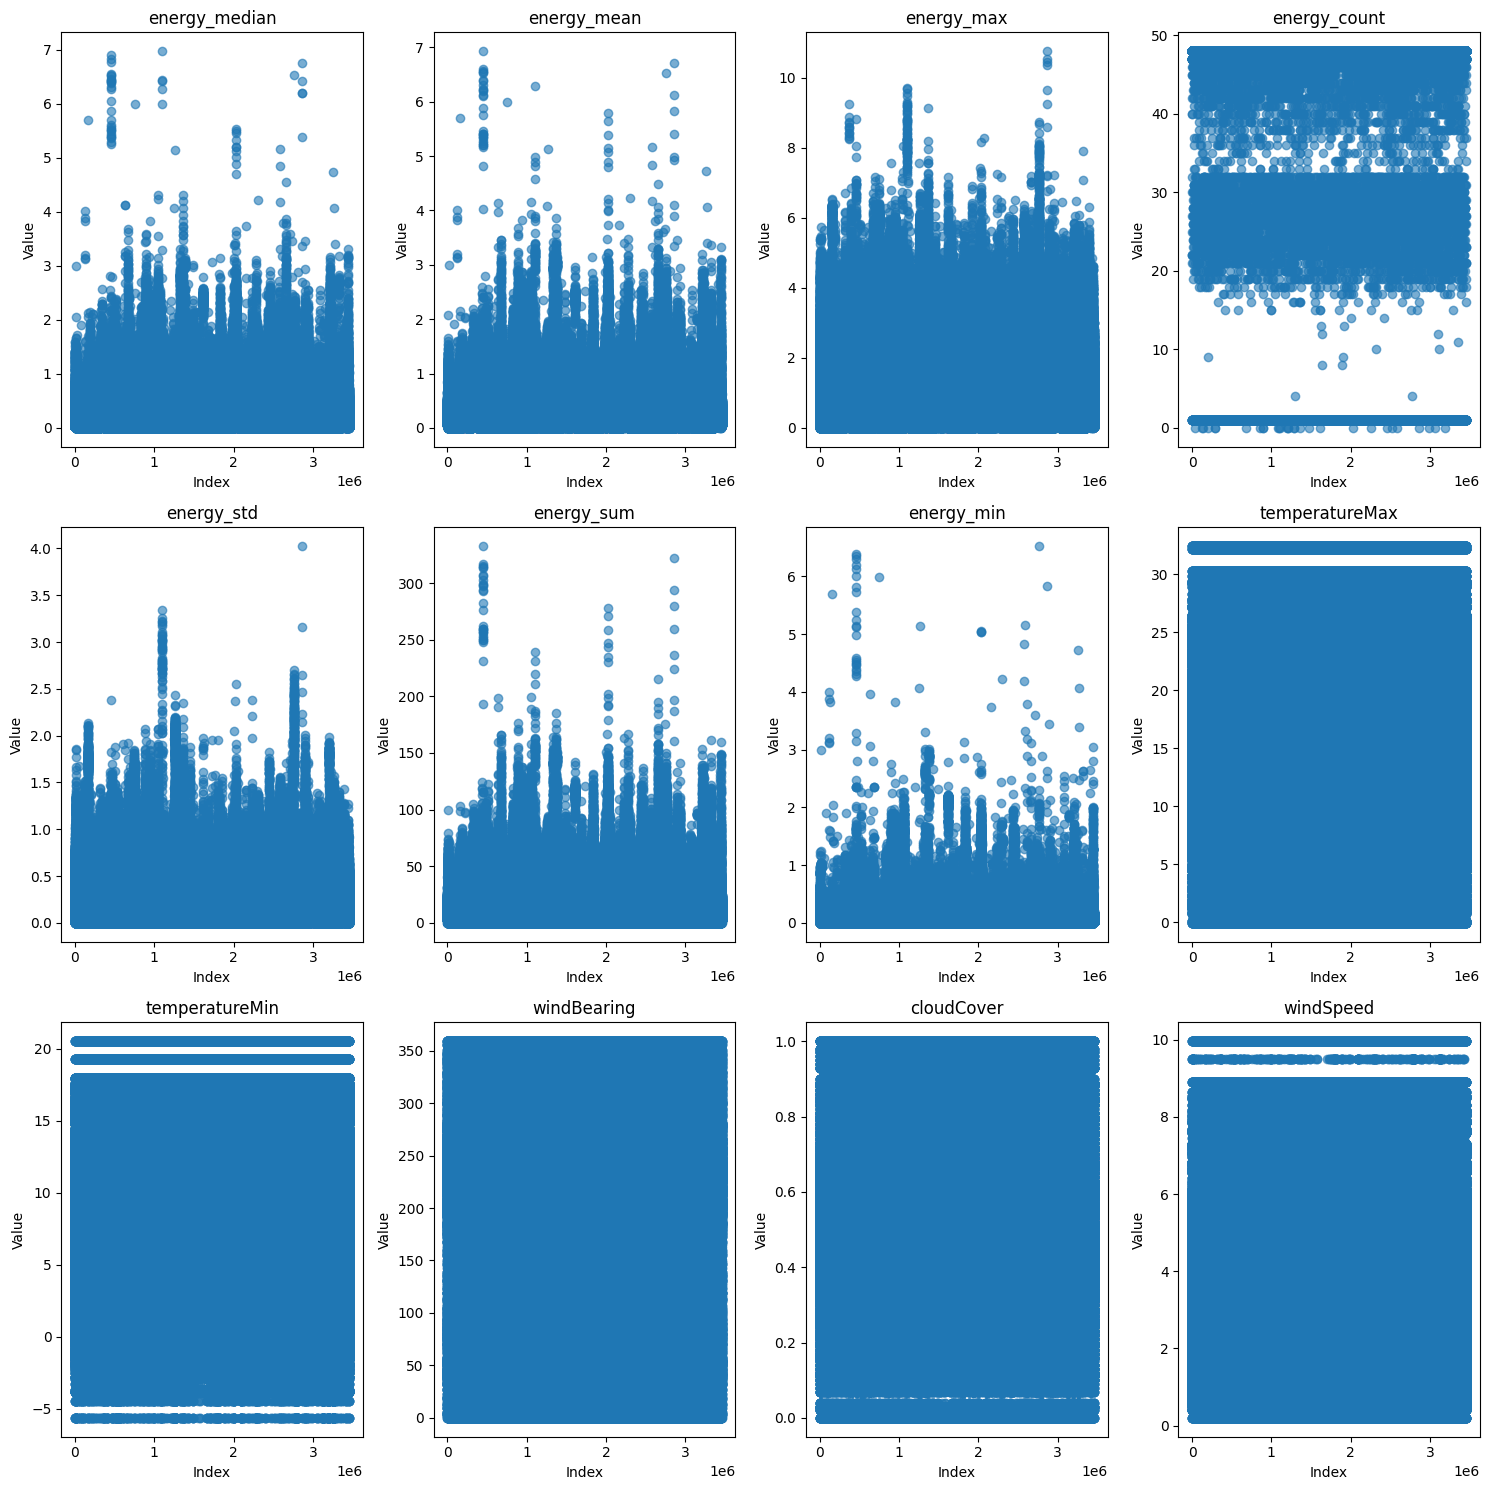

In [13]:
# outliers
import numpy as np
colums_to_drop = ['year', 'month', 'day_of_year']
final_df = final_df.drop(columns=colums_to_drop)
numerical_columns = final_df.select_dtypes(include=[np.number]).columns
num_cols = len(numerical_columns)

n_rows = int(np.ceil(num_cols / 4))

plt.figure(figsize=(15, n_rows * 5))

for i, column in enumerate(numerical_columns):
    plt.subplot(n_rows, 4, i + 1)
    plt.scatter(range(len(final_df)), final_df[column], alpha=0.6)
    plt.title(column)
    plt.xlabel('Index')
    plt.ylabel('Value')
plt.tight_layout()
plt.show()